In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sn

import glob
import random


In [2]:
# Set GPU device
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import glob

path = r'H:\Datasets\cic-ids-2018' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, low_memory=False, index_col=None, header=0)
    li.append(df)
    print("Read Completed for ", filename)

df = pd.concat(li, axis=0, ignore_index=True)

df = df.rename(columns={'label': 'Label'})

Read Completed for  H:\Datasets\cic-ids-2018\bot_02-03-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\bruteforce-web-xss_sql-injection_22-02-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\bruteforce-web-xss_sql-injection_23-02-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\ddos-loic-udp_hoic_21-02-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\dos-goldeneye-slowloris_15-02-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\dos-slowhttp-hulk_16-02-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\infiltration_01-03-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\infiltration_28-02-2018.csv


In [4]:
df["Label"].value_counts()

Benign                      5444525
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
Infilteration                161934
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                230
SQL Injection                    87
Name: Label, dtype: int64

In [5]:
print(df.shape)

(7235620, 80)


In [6]:
# Remove columns with only values of 0
useless_columns = ['dst_port', 'protocol', 'timestamp']
df.drop(labels=useless_columns, axis='columns', inplace=True)
print('After dropping some columns: \n\t there are {} columns and {} rows'.format(len(df.columns), len(df)))

features = df.columns

After dropping some columns: 
	 there are 77 columns and 7235620 rows


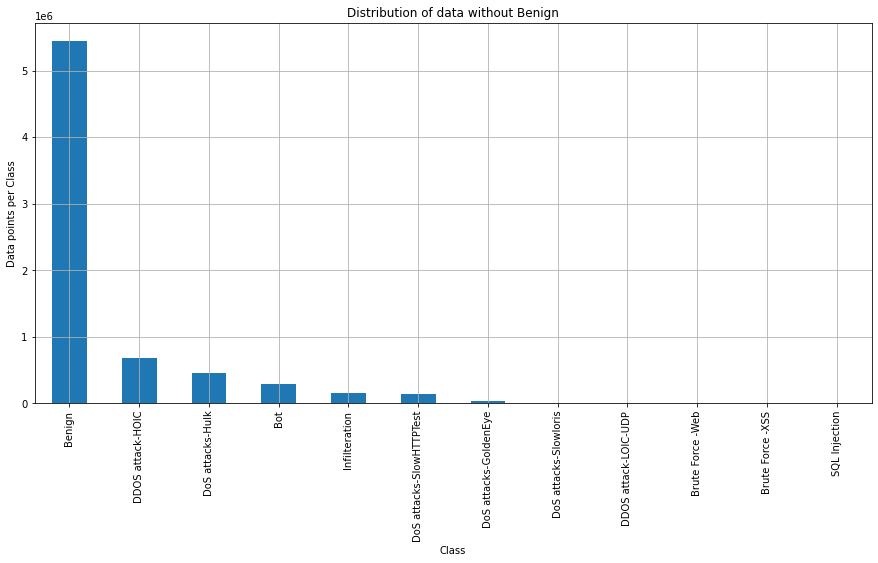

In [7]:
plt.figure(figsize=(15,7))
class_distribution = df[df["Label"] != "BENIGN"]["Label"].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of data without Benign')
plt.grid()
plt.show()

In [8]:
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

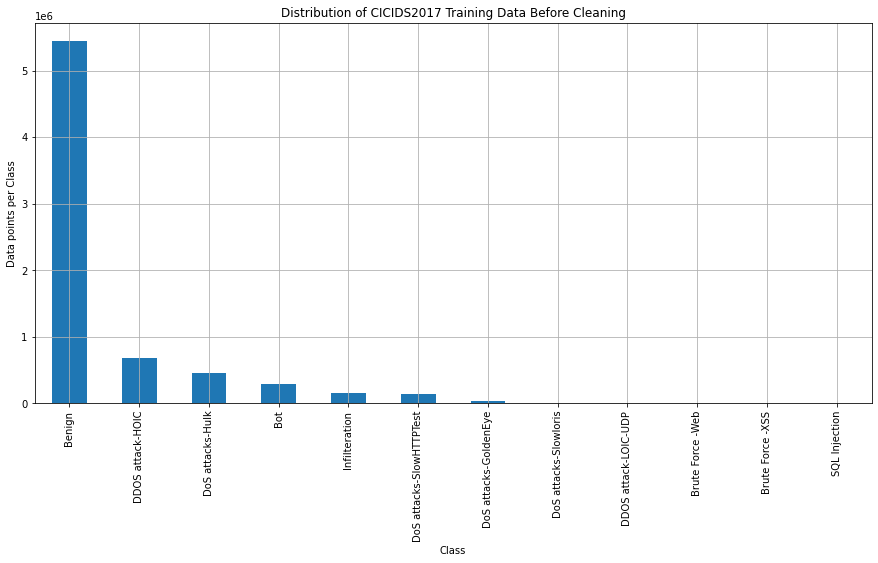

Number of data points in class Benign : 5444525 ( 75.246 %)
Number of data points in class DDOS attack-HOIC : 686012 ( 9.481 %)
Number of data points in class DoS attacks-Hulk : 461912 ( 6.384 %)
Number of data points in class Bot : 286191 ( 3.955 %)
Number of data points in class Infilteration : 161934 ( 2.238 %)
Number of data points in class DoS attacks-SlowHTTPTest : 139890 ( 1.933 %)
Number of data points in class DoS attacks-GoldenEye : 41508 ( 0.574 %)
Number of data points in class DoS attacks-Slowloris : 10990 ( 0.152 %)
Number of data points in class DDOS attack-LOIC-UDP : 1730 ( 0.024 %)
Number of data points in class Brute Force -Web : 611 ( 0.008 %)
Number of data points in class Brute Force -XSS : 230 ( 0.003 %)
Number of data points in class SQL Injection : 87 ( 0.001 %)


In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

plt.figure(figsize=(15,7))
class_distribution = df['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of CICIDS2017 Training Data Before Cleaning')
plt.grid()
plt.show()

# Before Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

In [11]:
del sorted_ds

#drop na values and reset index
data_clean = df.dropna().reset_index()

# Checkng for DUPLICATE values
data_clean.drop_duplicates(keep='first', inplace = True)

data_clean['Label'].value_counts()

print("Read {} rows.".format(len(data_clean)))

Read 7214943 rows.


In [12]:
analyze(data_clean)


7214943 rows
** index:7214943 (100%)
** flow_duration:2276311 (31%)
** tot_fwd_pkts:3534 (0%)
** tot_bwd_pkts:2527 (0%)
** totlen_fwd_pkts:15086 (0%)
** totlen_bwd_pkts:55856 (0%)
** fwd_pkt_len_max:1495 (0%)
** fwd_pkt_len_min:378 (0%)
** fwd_pkt_len_mean:74876 (1%)
** fwd_pkt_len_std:172162 (2%)
** bwd_pkt_len_max:1453 (0%)
** bwd_pkt_len_min:377 (0%)
** bwd_pkt_len_mean:127820 (1%)
** bwd_pkt_len_std:185297 (2%)
** flow_byts_s:3088543 (42%)
** flow_pkts_s:2753137 (38%)
** flow_iat_mean:2574633 (35%)
** flow_iat_std:3267832 (45%)
** flow_iat_max:1530887 (21%)
** flow_iat_min:417527 (5%)
** fwd_iat_tot:1970492 (27%)
** fwd_iat_mean:2296965 (31%)
** fwd_iat_std:2446852 (33%)
** fwd_iat_max:1575653 (21%)
** fwd_iat_min:502936 (6%)
** bwd_iat_tot:1398003 (19%)
** bwd_iat_mean:1678410 (23%)
** bwd_iat_std:2081006 (28%)
** bwd_iat_max:903930 (12%)
** bwd_iat_min:317698 (4%)
** fwd_psh_flags:[0:96.84%,1:3.16%]
** bwd_psh_flags:[0:100.0%]
** fwd_urg_flags:[0:99.96%,1:0.04%]
** bwd_urg_flags

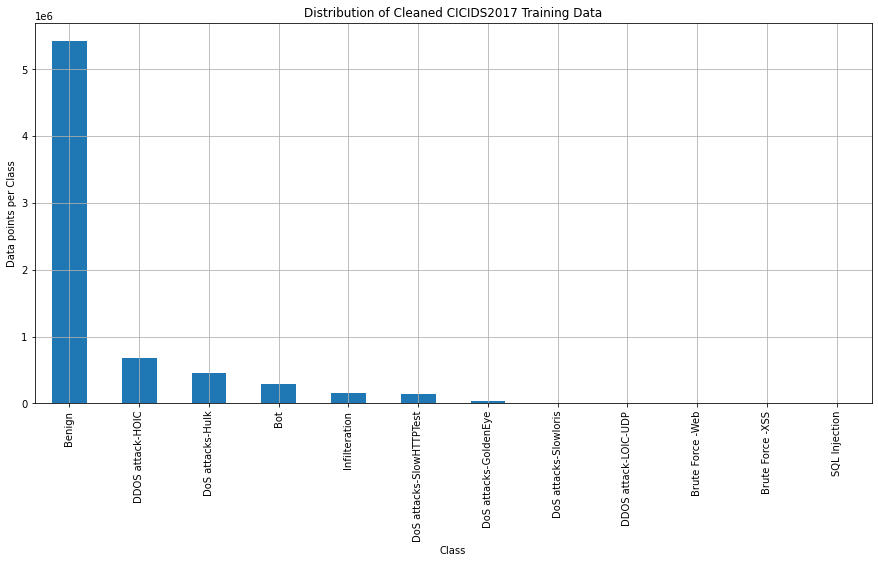

In [13]:
plt.figure(figsize=(15,7))
class_distribution = data_clean['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Cleaned CICIDS2017 Training Data')
plt.grid()
plt.show()

In [14]:
# After Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

Number of data points in class Benign : 5424686 ( 74.972 %)
Number of data points in class DDOS attack-HOIC : 686012 ( 9.481 %)
Number of data points in class DoS attacks-Hulk : 461912 ( 6.384 %)
Number of data points in class Bot : 286191 ( 3.955 %)
Number of data points in class Infilteration : 161096 ( 2.226 %)
Number of data points in class DoS attacks-SlowHTTPTest : 139890 ( 1.933 %)
Number of data points in class DoS attacks-GoldenEye : 41508 ( 0.574 %)
Number of data points in class DoS attacks-Slowloris : 10990 ( 0.152 %)
Number of data points in class DDOS attack-LOIC-UDP : 1730 ( 0.024 %)
Number of data points in class Brute Force -Web : 611 ( 0.008 %)
Number of data points in class Brute Force -XSS : 230 ( 0.003 %)
Number of data points in class SQL Injection : 87 ( 0.001 %)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


#drop na values and reset index
data_clean = df.dropna().reset_index()

# label encoding
labelencoder = LabelEncoder()
data_clean['Label'] = labelencoder.fit_transform(data_clean['Label'])

data_clean['Label'].value_counts()

data_np = data_clean.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

#del df

X = data_np[:, 0:76]

enc = OneHotEncoder()

Y = enc.fit_transform(data_np[:,77:]).toarray()

In [16]:
data_clean.shape

(7214943, 78)

In [17]:
print(data_clean.shape)

(7214943, 78)


In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2, shuffle=True)

_features = X.shape[1]
n_classes = Y.shape[1]

print('X.shape = ',X.shape)
print('Y.shape = ',Y.shape)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',Y_test.shape)

X.shape =  (7203137, 76)
Y.shape =  (7203137, 12)
X_train.shape =  (5402352, 76)
y_train.shape =  (5402352, 12)
X_test.shape =  (1800785, 76)
y_test.shape =  (1800785, 12)


In [19]:
print("X Shape: ", X.shape)
print("Y Shape: ", Y.shape)

X Shape:  (7203137, 76)
Y Shape:  (7203137, 12)


In [20]:
from keras import regularizers
from keras.layers import Dense, LeakyReLU, BatchNormalization, Input, LSTM, TimeDistributed, RepeatVector, Lambda
from keras import Input
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras import regularizers

In [21]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (5402352, 1, 76)
Test data shape: (1800785, 1, 76)


In [22]:
print('X.shape = ',X.shape)
print('Y.shape = ',Y.shape)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',Y_test.shape)

X.shape =  (7203137, 76)
Y.shape =  (7203137, 12)
X_train.shape =  (5402352, 1, 76)
y_train.shape =  (5402352, 12)
X_test.shape =  (1800785, 1, 76)
y_test.shape =  (1800785, 12)


In [23]:
print('Input Features: ', _features)
print('Input Classes: ', n_classes)

Input Features:  76
Input Classes:  12


# LSTM-AE Model

In [24]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(196, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(125, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(125, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(196, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# With default learning rate and mse loss function.

In [25]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse', metrics='accuracy') 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 76)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 196)            214032    
                                                                 
 lstm_1 (LSTM)               (None, 125)               161000    
                                                                 
 repeat_vector (RepeatVector  (None, 1, 125)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 125)            125500    
                                                                 
 lstm_3 (LSTM)               (None, 1, 196)            252448    
                                                             

In [26]:
# fit the model to the data
history = model.fit(X_train, X_train, epochs=5, batch_size=128, validation_split=0.05).history

Epoch 1/5
40096/40096 [==============================] - 431s 11ms/step - loss: 0.0179 - accuracy: 0.9321 - val_loss: 0.0167 - val_accuracy: 0.9458
Epoch 2/5
40096/40096 [==============================] - 451s 11ms/step - loss: 0.0144 - accuracy: 0.9521 - val_loss: 0.0113 - val_accuracy: 0.9725
Epoch 3/5
40096/40096 [==============================] - 448s 11ms/step - loss: 0.0137 - accuracy: 0.9626 - val_loss: 0.0096 - val_accuracy: 0.9775
Epoch 4/5
40096/40096 [==============================] - 447s 11ms/step - loss: 0.0101 - accuracy: 0.9717 - val_loss: 0.0087 - val_accuracy: 0.9785
Epoch 5/5
40096/40096 [==============================] - 439s 11ms/step - loss: 0.0097 - accuracy: 0.9807 - val_loss: 0.0076 - val_accuracy: 0.9838


In [27]:
import time

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

56275/56275 [==============================] - 113s 2ms/step
Inference time: 143.14 seconds


# With learning rate=0.0001 and mse loss function.

In [28]:
# create the autoencoder model
model = autoencoder_model(X_train)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='mse', metrics='accuracy') 
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 76)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 196)            214032    
                                                                 
 lstm_5 (LSTM)               (None, 125)               161000    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 125)           0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 1, 125)            125500    
                                                                 
 lstm_7 (LSTM)               (None, 1, 196)            252448    
                                                           

In [29]:
# fit the model to the data
history = model.fit(X_train, X_train, epochs=5, batch_size=128, validation_split=0.05).history

Epoch 1/5
40096/40096 [==============================] - 446s 11ms/step - loss: 0.0120 - accuracy: 0.9056 - val_loss: 0.0109 - val_accuracy: 0.9584
Epoch 2/5
40096/40096 [==============================] - 454s 11ms/step - loss: 0.0091 - accuracy: 0.9673 - val_loss: 0.0088 - val_accuracy: 0.9707
Epoch 3/5
40096/40096 [==============================] - 458s 11ms/step - loss: 0.0087 - accuracy: 0.9775 - val_loss: 0.0071 - val_accuracy: 0.9792
Epoch 4/5
40096/40096 [==============================] - 457s 11ms/step - loss: 0.0069 - accuracy: 0.9802 - val_loss: 0.0072 - val_accuracy: 0.9843
Epoch 5/5
40096/40096 [==============================] - 457s 11ms/step - loss: 0.0063 - accuracy: 0.9854 - val_loss: 0.0050 - val_accuracy: 0.9863


In [30]:
import time

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

56275/56275 [==============================] - 105s 2ms/step
Inference time: 120.71 seconds


# With default learning rate and mae loss function.

In [31]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae', metrics='accuracy') 
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 76)]           0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 196)            214032    
                                                                 
 lstm_9 (LSTM)               (None, 125)               161000    
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 125)           0         
 or)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 1, 125)            125500    
                                                                 
 lstm_11 (LSTM)              (None, 1, 196)            252448    
                                                           

In [32]:
# fit the model to the data
history = model.fit(X_train, X_train, epochs=5, batch_size=128, validation_split=0.05).history

Epoch 1/5
40096/40096 [==============================] - 456s 11ms/step - loss: 0.0104 - accuracy: 0.9416 - val_loss: 0.0089 - val_accuracy: 0.9539
Epoch 2/5
40096/40096 [==============================] - 457s 11ms/step - loss: 0.0062 - accuracy: 0.9657 - val_loss: 0.0069 - val_accuracy: 0.9745
Epoch 3/5
40096/40096 [==============================] - 470s 12ms/step - loss: 0.0059 - accuracy: 0.9687 - val_loss: 0.0065 - val_accuracy: 0.9749
Epoch 4/5
40096/40096 [==============================] - 467s 12ms/step - loss: 0.0053 - accuracy: 0.9751 - val_loss: 0.0058 - val_accuracy: 0.9764
Epoch 5/5
40096/40096 [==============================] - 462s 12ms/step - loss: 0.0054 - accuracy: 0.9794 - val_loss: 0.0056 - val_accuracy: 0.9818


In [33]:
import time

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

56275/56275 [==============================] - 117s 2ms/step
Inference time: 133.94 seconds


# With learning rate=0.0001 and mae loss function.

In [34]:
# create the autoencoder model
model = autoencoder_model(X_train)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='mae', metrics='accuracy') 
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 76)]           0         
                                                                 
 lstm_12 (LSTM)              (None, 1, 196)            214032    
                                                                 
 lstm_13 (LSTM)              (None, 125)               161000    
                                                                 
 repeat_vector_3 (RepeatVect  (None, 1, 125)           0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 1, 125)            125500    
                                                                 
 lstm_15 (LSTM)              (None, 1, 196)            252448    
                                                           

In [36]:
# fit the model to the data
history = model.fit(X_train, X_train, epochs=5, batch_size=128, validation_split=0.05).history

Epoch 1/5
80192/80192 [==============================] - 477s 11ms/step - loss: 0.0114 - accuracy: 0.9329 - val_loss: 0.0103 - val_accuracy: 0.9315
Epoch 2/5
80192/80192 [==============================] - 475s 12ms/step - loss: 0.0108 - accuracy: 0.9668 - val_loss: 0.0098 - val_accuracy: 0.9760
Epoch 3/5
80192/80192 [==============================] - 474s 12ms/step - loss: 0.0081 - accuracy: 0.9682 - val_loss: 0.0070 - val_accuracy: 0.9799
Epoch 4/5
80192/80192 [==============================] - 466s 11ms/step - loss: 0.0063 - accuracy: 0.9762 - val_loss: 0.0056 - val_accuracy: 0.9887
Epoch 5/5
80192/80192 [==============================] - 475s 11ms/step - loss: 0.0050 - accuracy: 0.9798 - val_loss: 0.0046 - val_accuracy: 0.9876


In [37]:
import time

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

56275/56275 [==============================] - 103s 2ms/step
Inference time: 118.21 seconds


# With default learning rate and mae loss function, to 30 epochs.

In [38]:
# create the autoencoder model
model = autoencoder_model(X_train)

model.compile(optimizer='adam', loss='mae', metrics='accuracy') 
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 76)]           0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 196)            214032    
                                                                 
 lstm_17 (LSTM)              (None, 125)               161000    
                                                                 
 repeat_vector_4 (RepeatVect  (None, 1, 125)           0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 1, 125)            125500    
                                                                 
 lstm_19 (LSTM)              (None, 1, 196)            252448    
                                                           

In [39]:
# fit the model to the data
history = model.fit(X_train, X_train, epochs=30, batch_size=128, validation_split=0.05).history

Epoch 1/30
40096/40096 [==============================] - 450s 11ms/step - loss: 0.0109 - accuracy: 0.9594 - val_loss: 0.0095 - val_accuracy: 0.9628
Epoch 2/30
40096/40096 [==============================] - 449s 11ms/step - loss: 0.0091 - accuracy: 0.9781 - val_loss: 0.0081 - val_accuracy: 0.9841
Epoch 3/30
40096/40096 [==============================] - 443s 11ms/step - loss: 0.0089 - accuracy: 0.9808 - val_loss: 0.0084 - val_accuracy: 0.9858
Epoch 4/30
40096/40096 [==============================] - 460s 11ms/step - loss: 0.0084 - accuracy: 0.9815 - val_loss: 0.0087 - val_accuracy: 0.9865
Epoch 5/30
40096/40096 [==============================] - 457s 11ms/step - loss: 0.0081 - accuracy: 0.9815 - val_loss: 0.0085 - val_accuracy: 0.9870
Epoch 6/30
40096/40096 [==============================] - 472s 12ms/step - loss: 0.0076 - accuracy: 0.9822 - val_loss: 0.0071 - val_accuracy: 0.9874
Epoch 7/30
40096/40096 [==============================] - 465s 12ms/step - loss: 0.0077 - accuracy: 0.9821

In [40]:
import time

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

56275/56275 [==============================] - 112s 2ms/step
Inference time: 128.24 seconds


In [41]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, auc
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


start = dt.datetime.now()

y_pred = model.predict(X_test)
escore = model.evaluate(X_test, X_test, batch_size=128)

# evaluate classification metrics (for multiclass targets)
#accuracy = accuracy_score(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
#precision = precision_score(Y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
#recall = recall_score(Y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
#f1 = f1_score(Y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
#confusion = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))



# print the results
#print("Accuracy: {:.3f}".format(accuracy))
#print("Precision: {:.3f}".format(precision))
#print("Recall: {:.3f}".format(recall))
#print("F1-score: {:.3f}".format(f1))
#print("Confusion Matrix:\n", confusion)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

14069/14069 [==============================] - 37s 3ms/step - loss: 0.0040 - accuracy: 0.9910
Completed
Time taken: 0:02:47.789283
